# Homework 1, Group A2

## FINM 37400 - 2024

### UChicago Financial Mathematics

* Mark Hendricks
* hendricks@uchicago.edu

# Group A2

This homework relies on the data file, `treasury_quotes_2023-07-26`.

#### Nominal Securities
The problems below analyze the nominal, (rather than the TIPS,) Treasury issues. Accordingly, you should filter out all rows with `ITYPE` of 11 or 12, as these indicate a TIPS Note or TIPS bond.


#### More Info
Find more info about many of the fields in the data set at the following link,

https://www.crsp.org/products/documentation/treasno-properties

Find the complete manual for the CRSP Treasury data at the following link,

https://www.crsp.org/files/treasury_guide_0.pdf

In [15]:
import pandas as pd
import numpy as np
import scipy.optimize as opt
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression

# Problem 1: Explore the Data

## 1 Maturity

For each issue, calculate its time-to-maturity, quoted in number of years, based on the issue and maturity dates. Assume a year has exactly 365.25 days.

Report the summary statistics of these time-to-maturities. Consider using `.describe()`.

In [16]:
rawdata=pd.read_excel('../data/treasury_quotes_2023-07-26.xlsx', sheet_name='quotes')
rawdata['Maturity_Date']=pd.to_datetime(rawdata['tmatdt'])
rawdata['time-to-maturity']=rawdata['Maturity_Date']-pd.to_datetime('2023-07-26')
rawdata['time-to-maturity']=rawdata['time-to-maturity'].apply(lambda x: x.days/365.25)
rawdata=rawdata[rawdata['itype']!=11]
rawdata=rawdata[rawdata['itype']!=12]
rawdata['time-to-maturity'].describe()

count    386.000000
mean       6.260656
std        8.004002
min        0.002738
25%        0.900068
50%        2.825462
75%        6.549624
max       29.637235
Name: time-to-maturity, dtype: float64

## 2 Prices 

Calculate the "dirty" price for each bond issue as
$$\text{price} = \frac{1}{2}(\text{TDBID} + \text{TDASK}) + \text{TDACCINT}$$
Namely, you are taking the midpoint of the bid and ask prices, and then you add the accrued interest.

We will discuss this adjustment for accrued interest later. For now, simply adjust as described in the formula.

In [17]:
rawdata['dirty_price']=((rawdata['tdask'] + rawdata['tdbid'])/2) + rawdata['tdaccint']
rawdata['dirty_price'].describe()

count    386.000000
mean      94.295832
std        8.861478
min       55.518003
25%       90.442515
50%       96.725210
75%       99.163511
max      114.621264
Name: dirty_price, dtype: float64

## 3 YTM

Write a function to calculate the yield-to-maturity for each issue. You will need to use a nonlinear solver to solve for the YTM.

Create a dataframe with the following columns:


| maturity | price | coupon rate | ytm | TDYLD | bid-ask |
|----------|-------|-------------|-----|----------|---------|

where 
* `maturity` refers to the time-to-maturity
* `TDYLD` is the YTM calculated by the data provider

Use `describe()` in pandas to to show descriptive statistics for this dataframe.

In [18]:
def get_yield(price, maturity, coupon):
    def bond_price(yield_):
        tp=0
        tt=((maturity*2)-int(maturity*2))/2
        while tt < maturity:
            tp+=(coupon/2)/(((1+(yield_/2))**(2*tt)))
            tt+=0.5
        tp+=(100+(coupon/2))/((1+(yield_/2))**(maturity*2))
        return price-tp
    return opt.root(bond_price, 0.04).x[0]/365.25

In [19]:
df=rawdata[['time-to-maturity','dirty_price','tcouprt','tdyld']].copy()
df['bid-ask']=rawdata['tdask'] - rawdata['tdbid']
df['yield']=df.apply(lambda x: get_yield(x['dirty_price'], x['time-to-maturity'], x['tcouprt']), axis=1)
df=df[['time-to-maturity','dirty_price','tcouprt','yield','tdyld','bid-ask']].copy()
df.rename(columns={'time-to-maturity':'maturity','dirty_price':'price','tcouprt':'coupon','yield':'ytm','tdyld':'TDYLD'}, inplace=True)
df.describe()

,maturity,price,coupon,ytm,TDYLD,bid-ask
count,386.000000,386.000000,386.000000,386.000000,386.000000,386.000000
mean,6.260656,94.295832,2.182642,0.000127,0.000126,0.036619
std,8.004002,8.861478,1.634226,0.000016,0.000015,0.018396
min,0.002738,55.518003,0.000000,0.000075,0.000075,0.000028
25%,0.900068,90.442515,0.750000,0.000113,0.000112,0.031250
50%,2.825462,96.725210,2.250000,0.000123,0.000122,0.031250
75%,6.549624,99.163511,3.125000,0.000144,0.000142,0.046875
max,29.637235,114.621264,7.625000,0.000167,0.000149,0.093750


## 4 Plots

Create scatter plots of...
* maturity versus price for all issues.
* maturity versus YTM for all issues.

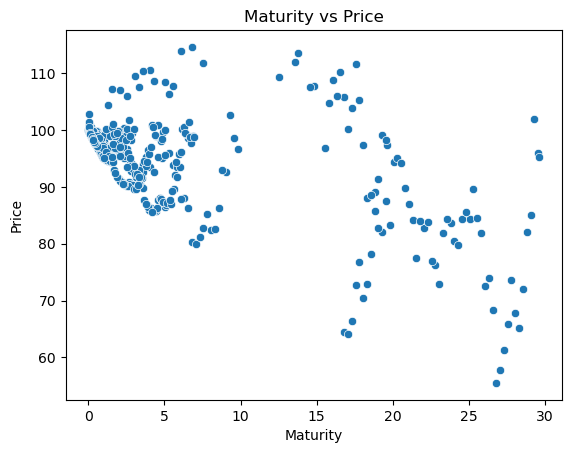

In [20]:
sns.scatterplot(data=df, x='maturity', y='price')
plt.title('Maturity vs Price')
plt.xlabel('Maturity')
plt.ylabel('Price')
plt.show()

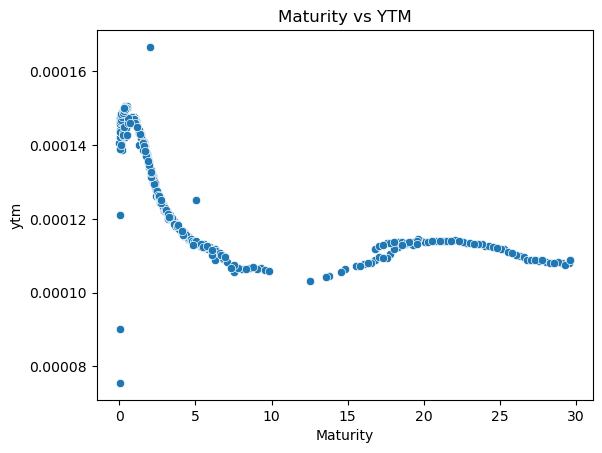

In [21]:
sns.scatterplot(data=df, x='maturity', y='ytm')
plt.title('Maturity vs YTM')
plt.xlabel('Maturity')
plt.ylabel('ytm')
plt.show()

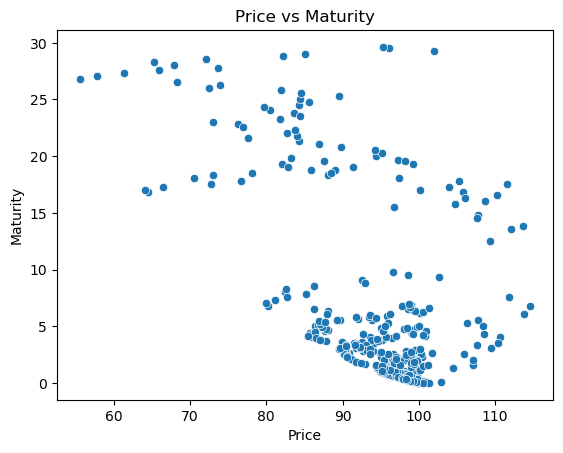

In [22]:
sns.scatterplot(data=df, x='price', y='maturity')
plt.title('Price vs Maturity')
plt.xlabel('Price')
plt.ylabel('Maturity')
plt.show()

## 5 Bad Data?

Find the issues where `TDYLD` is `NaN`. Display these rows from your table above. How many issues (rows) are effected?

What do you see in the other metrics for these issues that suggests that the price is bad?

In [23]:
print('Number of issues affected: ', len(df[df['TDYLD'].isnull()]))
df[df['TDYLD'].isnull()]

Number of issues affected:  0


,maturity,price,coupon,ytm,TDYLD,bid-ask


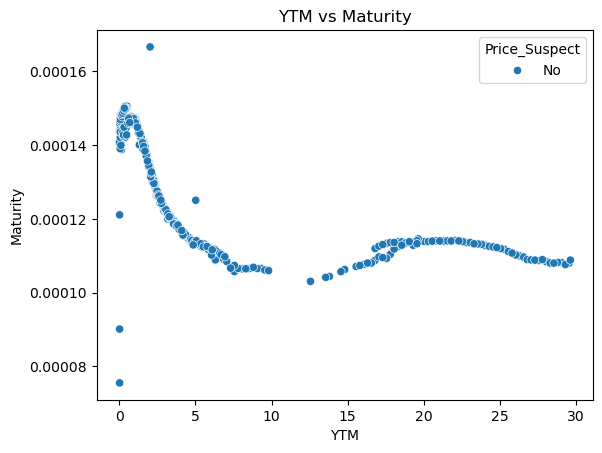

In [24]:
df['Price_Suspect'] = 'No'
df.loc[df['TDYLD'].isnull(), 'Price_Suspect'] = 'Yes'
sns.scatterplot(data=df, x='maturity', y='ytm', hue='Price_Suspect')
plt.title('YTM vs Maturity')
plt.xlabel('YTM')
plt.ylabel('Maturity')
plt.show()

In [25]:
len(df[df['Price_Suspect']=='No'])

386

***

# Problem 2: Extract the Discount Curve

## 1 Map Cashflows

Create the cashflow matrix, $\textbf{C}$, where each rows is a Treasury issue, each column is a date, and each entry is the cash paid on a (normalized) face value of \$100.

You will need to make a few modeling choices to do this...
* eliminate any treasury that does not report `TDYTM` or that reports a negative number for `TDYTM`.
* assume notes and bonds pay coupons every six months, going backward from the date of maturity.

Make other reasonable modeling assumptions as needed.

Report:
* head and tail rows of the dataframe, $\textbf{C}$, for instance, using `display()`.

* which date has the most cashflow across all issues?

* which date has the most issues paying a cashflow?

In [104]:
fdf = pd.concat([rawdata, df], axis=1)
fdf = fdf[fdf['Price_Suspect'] == 'No'].copy()
tCdf = []
for i in range(len(fdf)):
    row_data = {}
    crspid = fdf.iloc[i]['crspid']
    maturity = pd.to_datetime(fdf.iloc[i]['tmatdt'])
    coupon = fdf.iloc[i]['tcouprt']
    row_data['Issues'] = crspid
    row_data[maturity] = 100 + (coupon / 2)
    maturity = maturity - pd.DateOffset(months=6)
    while maturity > pd.to_datetime('2023-07-26'):
        row_data[maturity] = coupon / 2
        maturity = maturity - pd.DateOffset(months=6)
    tCdf.append(row_data)
Cdf = pd.DataFrame(tCdf)
Cdf.set_index('Issues', inplace=True, drop=True)
Cdf.sort_index(axis=1, inplace=True)

Cdf


,2023-07-27,2023-07-31,2023-08-01,2023-08-03,2023-08-08,2023-08-10,2023-08-15,2023-08-17,2023-08-22,2023-08-24,...,2051-09-15,2051-11-15,2052-02-15,2052-03-15,2052-05-15,2052-08-15,2052-09-15,2052-11-15,2053-02-15,2053-03-15
Issues,,,,,,,,,,,,,,,,,,,,,
20260215.106000,NaN,NaN,NaN,NaN,NaN,NaN,3.0000,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20271115.106120,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20290815.106120,NaN,NaN,NaN,NaN,NaN,NaN,3.0625,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20360215.104500,NaN,NaN,NaN,NaN,NaN,NaN,2.2500,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20370515.105000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20250531.204250,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20280531.203620,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20231214.400000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [106]:
date='2023-07-26'
maturity_col='tmatdt'
id_col='crspid'
coupon_col='tcouprt'
freq=2

def C_matrix(date, maturity_col, id_col, coupon_col, freq, fdf):
    '''Returns a dataframe with the cash flows of each bond in the dataset.
    date: string with to calculate cash flows from. Format: 'YYYY-MM-DD'
    maturity_col: string with the name of the column with the maturity date
    id_col: string with the name of the column with the bond id
    coupon_col: string with the name of the column with the coupon rate
    freq: integer with the number of coupon payments per year
    fdf: dataframe with the bond data'''
    tCdf = []
    for i in range(len(fdf)):
        row_data = {}
        crspid = fdf.iloc[i][id_col]
        maturity = pd.to_datetime(fdf.iloc[i][maturity_col])
        coupon = fdf.iloc[i][coupon_col]
        row_data['Issues'] = crspid
        row_data[maturity] = 100 + (coupon / freq)
        maturity = maturity - pd.DateOffset(months=int(12/freq))
        while maturity > pd.to_datetime(date):
            row_data[maturity] = coupon / freq
            maturity = maturity - pd.DateOffset(months=int(12/freq))
        tCdf.append(row_data)
    return pd.DataFrame(tCdf).set_index('Issues',drop=True).sort_index(axis=1)

testCdf=C_matrix(date, maturity_col, id_col, coupon_col, freq, fdf)
testCdf

,2023-07-27,2023-07-31,2023-08-01,2023-08-03,2023-08-08,2023-08-10,2023-08-15,2023-08-17,2023-08-22,2023-08-24,...,2051-09-15,2051-11-15,2052-02-15,2052-03-15,2052-05-15,2052-08-15,2052-09-15,2052-11-15,2053-02-15,2053-03-15
Issues,,,,,,,,,,,,,,,,,,,,,
20260215.106000,NaN,NaN,NaN,NaN,NaN,NaN,3.0000,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20271115.106120,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20290815.106120,NaN,NaN,NaN,NaN,NaN,NaN,3.0625,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20360215.104500,NaN,NaN,NaN,NaN,NaN,NaN,2.2500,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20370515.105000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20250531.204250,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20280531.203620,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20231214.400000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [27]:
print('Date with the largest cashflow: ', Cdf.sum(axis=0).idxmax(), ' with ', Cdf.sum(axis=0).max(), ' cashflow')
print('Date with the most issues paying a cashflow: ', Cdf.count().idxmax(), ' with ', Cdf.count().max(), ' issues')

Date with the largest cashflow:  2023-08-15 00:00:00  with  517.6875  cashflow
Date with the most issues paying a cashflow:  2023-08-15 00:00:00  with  76  issues


## 2 Bootstrap

Bootstrap the discount factors.

Starting with $C$ from the previous problem, further filter to create a subset of Treasury issues cashflow matrix $\tilde{C}$, such that each column has one, and only one, maturity. Also, each issue (row) has its face value payment in one of the columns.

The three step procedure below might be useful.

1. For dates with multiple bonds maturing, keep only that with the smallest bid-ask. If there are still multiple bonds maturing on the date, keep only that with the smallest coupon.

2. Only keep the first $L$ columns of the cashflow matrix, such that every column has a bond maturing on that date.

3. Eliminate any bonds, (rows,) that had maturity beyond column $L$.

This should produce the cashflow matrix, $\tilde{C}$.

**Report 5 head and tail rows of $\tilde{C}$.**

Solve the system of equations
$$\textbf{p} = \tilde{\textbf{C}}\, \textbf{z}_{\text{bootstrap}}$$

**Plot the estimated discount factors, $\textbf{z}$, against time-to-maturity.**

In [28]:
Cdft=Cdf.copy()
tba=fdf.copy()
tba.set_index('crspid', inplace=True, drop=True)

for i in range(len(Cdft.columns)):
    maturing=Cdft[Cdft[Cdft.columns[i]]>99].index
    if len(maturing) >= 1:
        keep=tba.loc[maturing,'bid-ask'].idxmin()
        val=tba.loc[maturing,'bid-ask'].min()
    for ii in maturing:
        if tba.loc[ii,'bid-ask'] > val:
            Cdft=Cdft.drop(ii)
    maturing=Cdft[Cdft[Cdft.columns[i]]>99].index
    if len(maturing) >= 1:
        keep=tba.loc[maturing,'coupon'].idxmin()
    for ii in maturing:
        if ii != keep:
            Cdft=Cdft.drop(ii)

keep=len(Cdft)
for i in Cdft.columns:
    maturing=len(Cdft[Cdft[i]>99])
    if maturing == 0:
        keep-=1
        Cdft=Cdft.drop(i, axis=1)
    if keep == 0:
        Cdft=Cdft.drop(i, axis=1)


for i in Cdft.index:
    if Cdft.loc[i].max() > 99:
        pass
    else:
        Cdft=Cdft.drop(i)


Cdft



,2023-07-27,2023-07-31,2023-08-01,2023-08-03,2023-08-08,2023-08-10,2023-08-15,2023-08-17,2023-08-22,2023-08-24,...,2051-02-15,2051-05-15,2051-08-15,2051-11-15,2052-02-15,2052-05-15,2052-08-15,2052-11-15,2053-02-15,2053-03-15
Issues,,,,,,,,,,,,,,,,,,,,,
20360215.104500,NaN,NaN,NaN,NaN,NaN,NaN,2.25,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20370515.105000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20380515.104500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20390815.104500,NaN,NaN,NaN,NaN,NaN,NaN,2.25,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20430515.102870,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20260415.203750,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20231109.400000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20231214.400000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


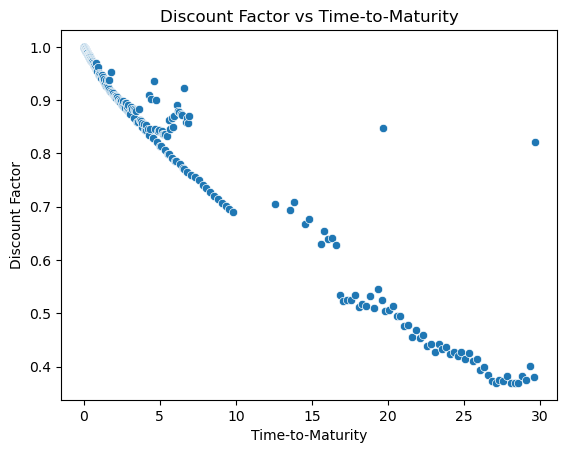

In [29]:
pairs={}
for i in Cdft.columns:
    expiring=Cdft[i].idxmax()
    if Cdft.loc[expiring].count() == 1:
        pairs[(i-pd.to_datetime('2023-07-23')).days/365.25]=tba.loc[expiring,'price']/Cdft.loc[expiring].max()
    else:
        tp=tba.loc[expiring,'price']
        for ii in Cdft.loc[expiring][Cdft.loc[expiring]>0].index[:-1]:
            tp-=tba.loc[expiring,'coupon']*pairs[(ii-pd.to_datetime('2023-07-23')).days/365.25]/2
        pairs[(i-pd.to_datetime('2023-07-23')).days/365.25]=tp/Cdft.loc[expiring].max()

tdata=pd.DataFrame.from_dict(pairs, orient='index')
tdata.rename(columns={0:'Discount_Factor'}, inplace=True)
sns.scatterplot(data=tdata, x=tdata.index, y='Discount_Factor')
plt.title('Discount Factor vs Time-to-Maturity')
plt.xlabel('Time-to-Maturity')
plt.ylabel('Discount Factor')
plt.show()

In [44]:
tttprices=tba['price'][Cdft.index]
tttprices

Issues
20360215.104500    109.306069
20370515.105000    113.634511
20380515.104500    107.802310
20390815.104500    108.720131
20430515.102870     83.269531
                      ...    
20260415.203750     98.966957
20231109.400000     98.451222
20231214.400000     97.937875
20300630.203750     98.718071
20231121.400000     98.268514
Name: price, Length: 259, dtype: float64

In [76]:
model=LinearRegression(fit_intercept=False)
model.fit(Cdft.fillna(0), tttprices)
model.coef_

array([0.99986111, 0.99962532, 0.99915   , 0.99886333, 0.99812222,
       0.99784583, 0.99709722, 0.99679778, 0.99606063, 0.99580507,
       0.99507472, 0.994765  , 0.99402653, 0.99371722, 0.993     ,
       0.99270833, 0.99303424, 0.99197153, 0.99167958, 0.99091528,
       0.99064   , 0.99078696, 0.989995  , 0.98962118, 0.98898   ,
       0.988625  , 0.98859767, 0.98789007, 0.98757465, 0.98684375,
       0.98653222, 0.98584069, 0.98552812, 0.98486222, 0.98451222,
       0.9838125 , 0.98411449, 0.98350514, 0.98268514, 0.98228694,
       0.9816059 , 0.98133806, 0.98032806, 0.97937875, 0.98026955,
       0.978355  , 0.97733125, 0.97731365, 0.97631875, 0.97523681,
       0.97591179, 0.97428444, 0.97318542, 0.97300669, 0.9710446 ,
       0.97013764, 0.96880352, 0.96696915, 0.96597569, 0.96453338,
       0.96246496, 0.96184125, 0.97010533, 0.95813944, 0.95812639,
       0.95587547, 0.9542641 , 0.95399504, 0.96152436, 0.9503725 ,
       0.94989963, 0.94777177, 0.94589151, 0.94357435, 0.94200

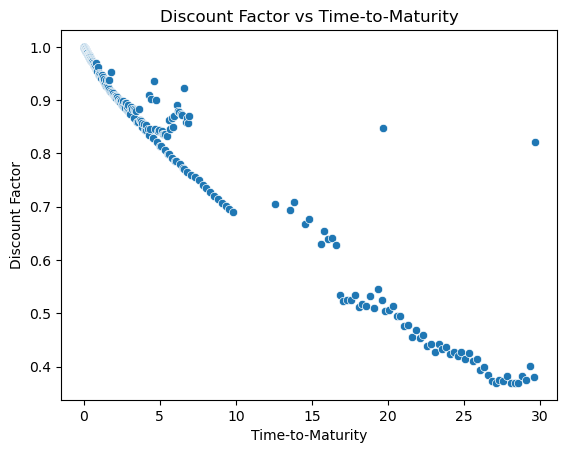

In [94]:
plot=pd.DataFrame([(Cdft.columns[i]-pd.to_datetime('2023-07-23')).days/365.25 for i in range(len(Cdft.columns))], columns=['Time-to-Maturity'])
plot['Discount_Factor']=model.coef_
sns.scatterplot(data=plot, x='Time-to-Maturity', y='Discount_Factor')
plt.title('Discount Factor vs Time-to-Maturity')
plt.xlabel('Time-to-Maturity')
plt.ylabel('Discount Factor')
plt.show()

In [93]:
tttprices

Issues
20360215.104500    109.306069
20370515.105000    113.634511
20380515.104500    107.802310
20390815.104500    108.720131
20430515.102870     83.269531
                      ...    
20260415.203750     98.966957
20231109.400000     98.451222
20231214.400000     97.937875
20300630.203750     98.718071
20231121.400000     98.268514
Name: price, Length: 259, dtype: float64

## 3. OLS

Estimate the discount factors using OLS.

Starting with the cashflow matrix, $C$, create an additional filter to get a subset where every date has at least one maturity, (possibly multiple,) and every issue has its maturity in the cashflow matrix. (You might do something similar to the three-step procedure of the bootstrap, but skip step #1.) Call this set of cashflows, $\hat{C}$.

**Report 5 head and tail rows of $\hat{C}$.**

$$\textbf{p} = \hat{\textbf{C}}\,\textbf{z}_{\text{ols}}+\epsilon$$

**Plot the discount factors against maturities.**

In [30]:
Cols=Cdf.copy()

keep=len(Cols)
for i in Cols.columns:
    maturing=len(Cols[Cols[i]>99])
    if maturing == 0:
        keep-=1
        Cols=Cols.drop(i, axis=1)
    if keep == 0:
        Cols=Cols.drop(i, axis=1)

for i in Cols.index:
    if Cols.loc[i].max() > 99:
        pass
    else:
        Cols=Cols.drop(i)

Cols

,2023-07-27,2023-07-31,2023-08-01,2023-08-03,2023-08-08,2023-08-10,2023-08-15,2023-08-17,2023-08-22,2023-08-24,...,2051-02-15,2051-05-15,2051-08-15,2051-11-15,2052-02-15,2052-05-15,2052-08-15,2052-11-15,2053-02-15,2053-03-15
Issues,,,,,,,,,,,,,,,,,,,,,
20260215.106000,NaN,NaN,NaN,NaN,NaN,NaN,3.0000,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20271115.106120,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20290815.106120,NaN,NaN,NaN,NaN,NaN,NaN,3.0625,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20360215.104500,NaN,NaN,NaN,NaN,NaN,NaN,2.2500,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20370515.105000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20250531.204250,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20280531.203620,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20231214.400000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


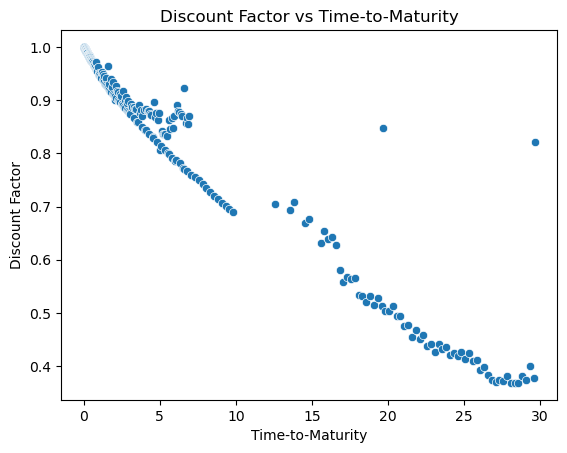

In [31]:
pairs_ols={}
for i in Cols.columns:
    expiring=Cols[Cols[i]>99].index
    if len(expiring) == 1:
        if Cols.loc[expiring[0]].count() == 1:
            pairs_ols[(i-pd.to_datetime('2023-07-23')).days/365.25]=tba.loc[expiring[0],'price']/Cols.loc[expiring[0]].max()
        else:
            tp=tba.loc[expiring[0],'price']
            for ii in Cols.loc[expiring[0]][Cols.loc[expiring[0]]>0].index[:-1]:
                tp-=tba.loc[expiring[0],'coupon']*pairs_ols[(ii-pd.to_datetime('2023-07-23')).days/365.25]/2
            pairs_ols[(i-pd.to_datetime('2023-07-23')).days/365.25]=tp/Cols.loc[expiring[0]].max()
    else:
        tprices=[]
        tcashflows=[]
        if Cols.loc[expiring[0]].count() == 1:
            for ii in expiring:
                tprices.append(tba.loc[ii,'price'])
                tcashflows.append(Cols.loc[ii].max())
            tmodel=LinearRegression(fit_intercept=False)
            tmodel.fit(np.array(tcashflows).reshape(-1,1), tprices)
            pairs_ols[(i-pd.to_datetime('2023-07-23')).days/365.25]=tmodel.coef_[0]
        else:
            for ii in expiring:
                tp=tba.loc[ii,'price']
                for iii in Cols.loc[ii][Cols.loc[ii]>0].index[:-1]:
                    tp-=tba.loc[ii,'coupon']*pairs_ols[(iii-pd.to_datetime('2023-07-23')).days/365.25]/2
                tprices.append(tp)
                tcashflows.append(Cols.loc[ii].max())
            tmodel=LinearRegression(fit_intercept=False)
            tmodel.fit(np.array(tcashflows).reshape(-1,1), tprices)
            pairs_ols[(i-pd.to_datetime('2023-07-23')).days/365.25]=tmodel.coef_[0]                

tdata=pd.DataFrame.from_dict(pairs_ols, orient='index')
tdata.rename(columns={0:'Discount_Factor'}, inplace=True)
sns.scatterplot(data=tdata, x=tdata.index, y='Discount_Factor')
plt.title('Discount Factor vs Time-to-Maturity')
plt.xlabel('Time-to-Maturity')
plt.ylabel('Discount Factor')
plt.show()

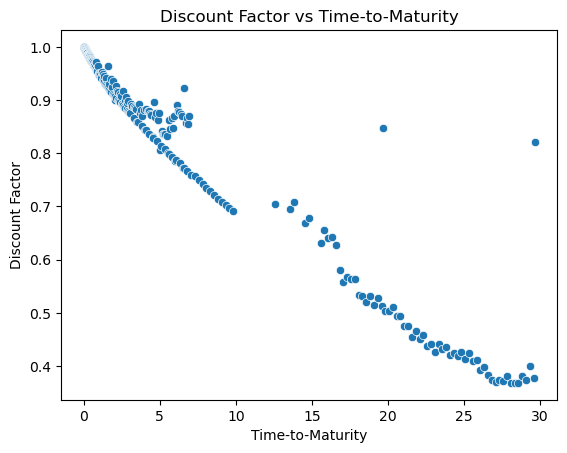

In [96]:
model=LinearRegression(fit_intercept=False)
model.fit(Cols.fillna(0), tba['price'][Cols.index])
plot=pd.DataFrame([(Cdft.columns[i]-pd.to_datetime('2023-07-23')).days/365.25 for i in range(len(Cdft.columns))], columns=['Time-to-Maturity'])
plot['Discount_Factor']=model.coef_
sns.scatterplot(data=plot, x='Time-to-Maturity', y='Discount_Factor')
plt.title('Discount Factor vs Time-to-Maturity')
plt.xlabel('Time-to-Maturity')
plt.ylabel('Discount Factor')
plt.show()

## 4 Factors and Rates

Convert $\textbf{z}_{\text{bootstrap}}$ to a set of 
* continuous discount rates
* semiannually compounded discount rates

Do the same for $\textbf{z}_{\text{ols}}$.

Plot the **continuous** discount rates generated via bootstrap and via OLS against time-to-maturity.

Plot the **semiannually compounded** discount rates generated via bootstrap and via OLS against time-to-maturity.

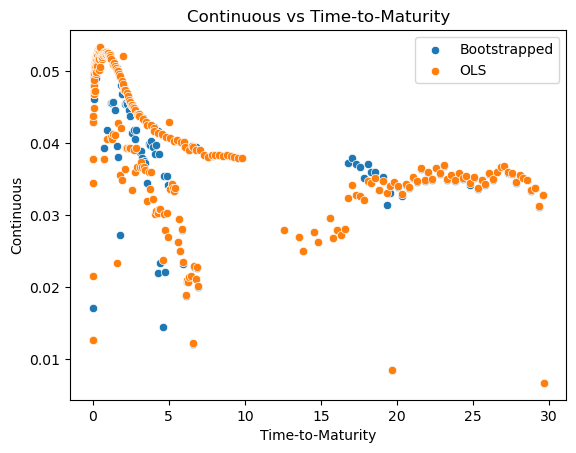

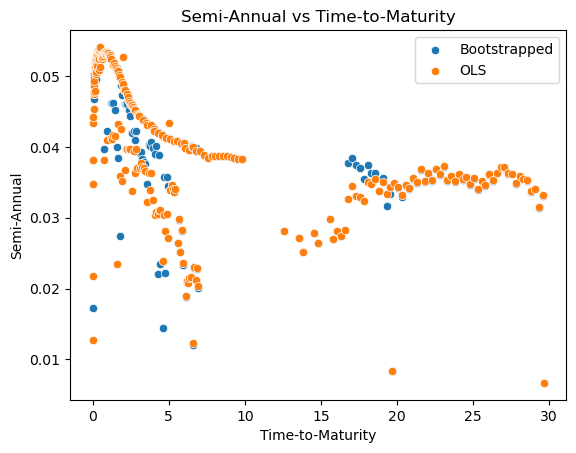

In [32]:
Zboot=pd.DataFrame()
for i in pairs:
    Zboot.loc[i,'continuous']=-np.log(pairs[i])/i
    Zboot.loc[i,'semi_anual']=((1/pairs[i])**(1/(2*i))-1)*2

Zols=pd.DataFrame()
for i in pairs_ols:
    Zols.loc[i,'continuous']=-np.log(pairs_ols[i])/i
    Zols.loc[i,'semi_anual']=((1/pairs_ols[i])**(1/(2*i))-1)*2

sns.scatterplot(data=Zboot, x=Zboot.index, y='continuous', label='Bootstrapped')
sns.scatterplot(data=Zols, x=Zols.index, y='continuous', label='OLS')
plt.title('Continuous vs Time-to-Maturity')
plt.legend()
plt.xlabel('Time-to-Maturity')
plt.ylabel('Continuous')
plt.show()

sns.scatterplot(data=Zboot, x=Zboot.index, y='semi_anual', label='Bootstrapped')
sns.scatterplot(data=Zols, x=Zols.index, y='semi_anual', label='OLS')
plt.title('Semi-Annual vs Time-to-Maturity')
plt.legend()
plt.xlabel('Time-to-Maturity')
plt.ylabel('Semi-Annual')
plt.show()

In [33]:
print('------Bootstrapped------')
display(Zboot)

print('------OLS------')
display(Zols)

------Bootstrapped------


,continuous,semi_anual
0.010951,0.012683,0.012723
0.021903,0.017110,0.017183
0.024641,0.034511,0.034810
0.030116,0.037764,0.038123
0.043806,0.042906,0.043370
...,...,...
28.813142,0.033336,0.033615
29.065024,0.033703,0.033989
29.316906,0.031128,0.031372
29.568789,0.032731,0.033001


------OLS------


,continuous,semi_anual
0.010951,0.012683,0.012723
0.021903,0.021597,0.021714
0.024641,0.034511,0.034810
0.030116,0.037764,0.038123
0.043806,0.042906,0.043370
...,...,...
28.813142,0.033455,0.033736
29.065024,0.033811,0.034099
29.316906,0.031281,0.031527
29.568789,0.032856,0.033127


***

# Problem 3: Nelson-Siegel Curve

Use the Nelson-Siegel curve to model the discount rates. 

Fit them via minimizing the sum of squared errors for the prices imputed by the model versus the quoted prices. 

Consider using `minimize` from `scipy.optimize`.

* Estimate the model three times, using $\textbf{C}$, $\tilde{\textbf{C}}$, $\hat{\textbf{C}}$.

* Plot the estimated discount factors, $\textbf{z}_{\text{ns}}$ against time-to-maturity.

* Also plot the associated continuously-compounded discount rates.

$\begin{align}
r(t,T) =& f(T-t,\boldsymbol{\theta})\\
=& \theta_0 + (\theta_1 + \theta_2)\frac{1-e^{-T/\lambda}}{T/\lambda} - \theta_2 e^{-T/\lambda}
\end{align}
$

In [97]:
def estimate_ns(params, *args):
    M, tba = args[0], args[1]
    t0, t1, t2, lam = params[0], params[1], params[2], params[3]
    tM=M.copy()
    times=tM.columns
    times=(pd.to_datetime(times)-pd.to_datetime('2023-07-23')).days/365.25
    tM.columns=times
    error=0
    for i in tM.index:
        price=0
        tM.loc[i][tM.loc[i]>0].index
        for ii in tM.loc[i][tM.loc[i]>0].index:
            rate=t0+((t1+t2)*((1-np.exp(-ii/lam))/(ii/lam)))-t2*np.exp(-ii/lam)
            price+=tM.loc[i,ii]*np.exp(-rate*ii)
        error+=(price-tba.loc[i,'price'])**2
    return error

nsCdf=opt.minimize(estimate_ns, [0.01, 0.01, 0.01, 1], args=(Cdf, tba), method='L-BFGS-B')
nsCdft=opt.minimize(estimate_ns, [0.01, 0.01, 0.01, 1], args=(Cdft, tba), method='L-BFGS-B')
nsCols=opt.minimize(estimate_ns, [0.01, 0.01, 0.01, 1], args=(Cols, tba), method='L-BFGS-B')

In [100]:
def estimate_ns(*args):
    '''Make sure first argument is the C matrix (columns are times and rows are issues) and the second argument is a dataframe with a "price" column and same index.
    Results are called through the .x attribute of the returned object. 0 is t0, 1 is t1, 2 is t2, and 3 is lambda.'''
    def estimate_ns(params, *args):
        M, tba = args[0], args[1]
        t0, t1, t2, lam = params[0], params[1], params[2], params[3]
        tM=M.copy()
        times=tM.columns
        times=(pd.to_datetime(times)-pd.to_datetime('2023-07-23')).days/365.25
        tM.columns=times
        error=0
        for i in tM.index:
            price=0
            tM.loc[i][tM.loc[i]>0].index
            for ii in tM.loc[i][tM.loc[i]>0].index:
                rate=t0+((t1+t2)*((1-np.exp(-ii/lam))/(ii/lam)))-t2*np.exp(-ii/lam)
                price+=tM.loc[i,ii]*np.exp(-rate*ii)
            error+=(price-tba.loc[i,'price'])**2
        return error
    return opt.minimize(estimate_ns, [0.01, 0.01, 0.01, 1], args=(args), method='L-BFGS-B')

nsCdf=estimate_ns(Cdf, tba)
nsCdft=estimate_ns(Cdft, tba)
nsCols=estimate_ns(Cols, tba)


In [101]:
print('\n ------C1 results------')
print('t0: ', nsCdf.x[0])
print('t1: ', nsCdf.x[1])
print('t2: ', nsCdf.x[2])
print('lambda: ', nsCdf.x[3])
print('error: ', nsCdf.fun)
print('\n ------C2 results------')
print('t0: ', nsCdft.x[0])
print('t1: ', nsCdft.x[1])
print('t2: ', nsCdft.x[2])
print('lambda: ', nsCdft.x[3])
print('error: ', nsCdft.fun)
print('\n ------C3 results------')
print('t0: ', nsCols.x[0])
print('t1: ', nsCols.x[1])
print('t2: ', nsCols.x[2])
print('lambda: ', nsCols.x[3])
print('error: ', nsCols.fun)


 ------C1 results------
t0:  0.04155141295651282
t1:  0.0199833541766511
t2:  -0.03211709732825308
lambda:  2.4718578146180383
error:  145.91793547392345

 ------C2 results------
t0:  0.03529503721129459
t1:  0.031165056913609906
t2:  -0.04713175296620821
lambda:  2.337818932397118
error:  5059.913400704763

 ------C3 results------
t0:  0.03522585072946493
t1:  0.023643804411229027
t2:  -0.03831956030548699
lambda:  2.5702383181492463
error:  5619.263548716182


In [99]:
print('\n ------C1 results------')
print('t0: ', nsCdf.x[0])
print('t1: ', nsCdf.x[1])
print('t2: ', nsCdf.x[2])
print('lambda: ', nsCdf.x[3])
print('error: ', nsCdf.fun)
print('\n ------C2 results------')
print('t0: ', nsCdft.x[0])
print('t1: ', nsCdft.x[1])
print('t2: ', nsCdft.x[2])
print('lambda: ', nsCdft.x[3])
print('error: ', nsCdft.fun)
print('\n ------C3 results------')
print('t0: ', nsCols.x[0])
print('t1: ', nsCols.x[1])
print('t2: ', nsCols.x[2])
print('lambda: ', nsCols.x[3])
print('error: ', nsCols.fun)


 ------C1 results------
t0:  0.04155141295651282
t1:  0.0199833541766511
t2:  -0.03211709732825308
lambda:  2.4718578146180383
error:  145.91793547392345

 ------C2 results------
t0:  0.03529503721129459
t1:  0.031165056913609906
t2:  -0.04713175296620821
lambda:  2.337818932397118
error:  5059.913400704763

 ------C3 results------
t0:  0.03522585072946493
t1:  0.023643804411229027
t2:  -0.03831956030548699
lambda:  2.5702383181492463
error:  5619.263548716182


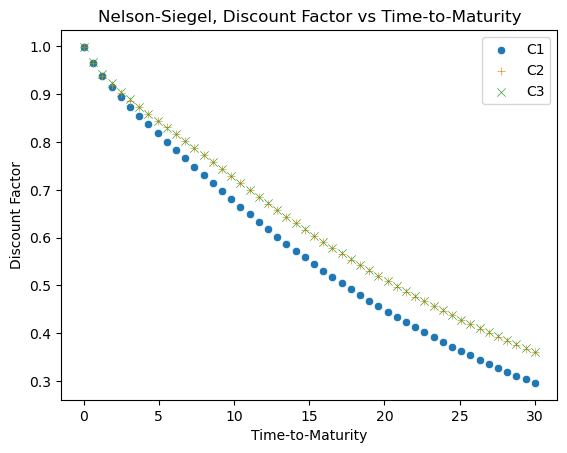

In [36]:
tx=np.linspace(0.02, 30, 50)
ty=np.exp(-(nsCdf.x[0]+((nsCdf.x[1]+nsCdf.x[2])*((1-np.exp(-tx/nsCdf.x[3]))/(tx/nsCdf.x[3])))-nsCdf.x[2]*np.exp(-tx/nsCdf.x[3]))*tx)
sns.scatterplot(x=tx, y=ty, label='C1', marker='o')
ty=np.exp(-(nsCdft.x[0]+((nsCdft.x[1]+nsCdft.x[2])*((1-np.exp(-tx/nsCdft.x[3]))/(tx/nsCdft.x[3])))-nsCdft.x[2]*np.exp(-tx/nsCdft.x[3]))*tx)
sns.scatterplot(x=tx, y=ty, label='C2', marker='+')
ty=np.exp(-(nsCols.x[0]+((nsCols.x[1]+nsCols.x[2])*((1-np.exp(-tx/nsCols.x[3]))/(tx/nsCols.x[3])))-nsCols.x[2]*np.exp(-tx/nsCols.x[3]))*tx)
sns.scatterplot(x=tx, y=ty, label='C3', marker='x')
plt.title('Nelson-Siegel, Discount Factor vs Time-to-Maturity')
plt.legend()
plt.xlabel('Time-to-Maturity')
plt.ylabel('Discount Factor')
plt.show()

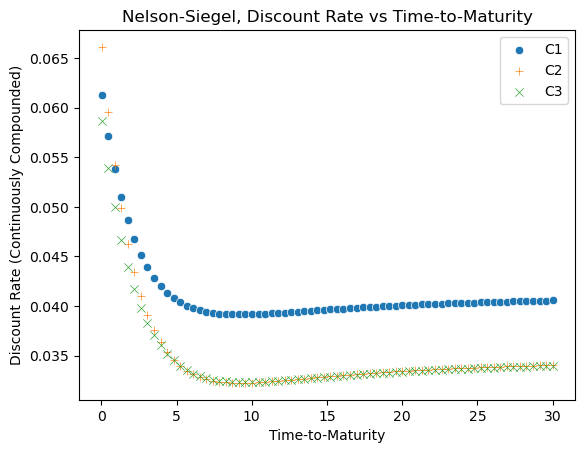

In [37]:
tx=np.linspace(0.02, 30, 70)
ty=(nsCdf.x[0]+((nsCdf.x[1]+nsCdf.x[2])*((1-np.exp(-tx/nsCdf.x[3]))/(tx/nsCdf.x[3])))-nsCdf.x[2]*np.exp(-tx/nsCdf.x[3]))
sns.scatterplot(x=tx, y=ty, label='C1', marker='o')
ty=(nsCdft.x[0]+((nsCdft.x[1]+nsCdft.x[2])*((1-np.exp(-tx/nsCdft.x[3]))/(tx/nsCdft.x[3])))-nsCdft.x[2]*np.exp(-tx/nsCdft.x[3]))
sns.scatterplot(x=tx, y=ty, label='C2', marker='+')
ty=(nsCols.x[0]+((nsCols.x[1]+nsCols.x[2])*((1-np.exp(-tx/nsCols.x[3]))/(tx/nsCols.x[3])))-nsCols.x[2]*np.exp(-tx/nsCols.x[3]))
sns.scatterplot(x=tx, y=ty, label='C3', marker='x')
plt.title('Nelson-Siegel, Discount Rate vs Time-to-Maturity')
plt.legend()
plt.xlabel('Time-to-Maturity')
plt.ylabel('Discount Rate (Continuously Compounded)')
plt.show()

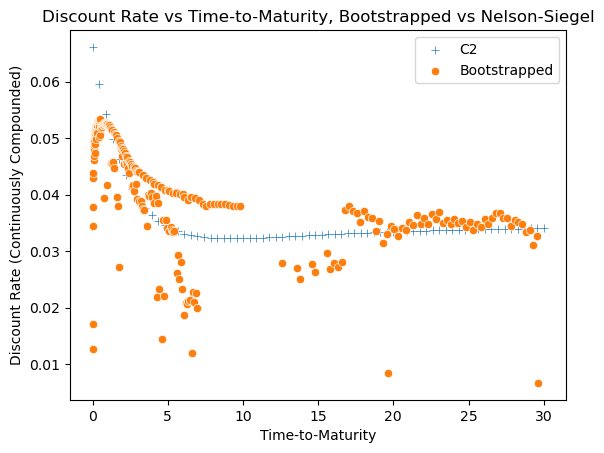

In [38]:
tx=np.linspace(0.02, 30, 70)
ty=nsCdft.x[0]+((nsCdft.x[1]+nsCdft.x[2])*((1-np.exp(-tx/nsCdft.x[3]))/(tx/nsCdft.x[3])))-nsCdft.x[2]*np.exp(-tx/nsCdft.x[3])
sns.scatterplot(x=tx, y=ty, label='C2', marker='+')
tdata=pd.DataFrame.from_dict(pairs, orient='index')
tdata.rename(columns={0:'Discount_Factor'}, inplace=True)
tdata['Discount_Rate']=-np.log(tdata['Discount_Factor'])/tdata.index
sns.scatterplot(data=tdata, x=tdata.index, y='Discount_Rate', label='Bootstrapped')
plt.title('Discount Rate vs Time-to-Maturity, Bootstrapped vs Nelson-Siegel')
plt.legend()
plt.xlabel('Time-to-Maturity')
plt.ylabel('Discount Rate (Continuously Compounded)')
plt.show()